<a href="https://colab.research.google.com/github/alsh626626/CE888/blob/main/Lab_3/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
import sklearn

from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder

Load the data from bank-additional-full.csv

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv", delimiter = ";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df.shape

(41188, 21)

# Data preprocessing

Use LabelEncoder to convert the label into numbers

In [ ]:
# convert a string variable to a categorical one
df[["y"]] = df[["y"]].apply(LabelEncoder().fit_transform)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


Perform one-hot encoding on the categorical features using df_dummies = pd.get_dummies(df)

In [ ]:
df_dummies = pd.get_dummies(df)

Column "duration" must be deleted

In [ ]:
df_dummies.drop(columns='duration',inplace=True)

Check if there are any missing values in the dataset. If there are, drop the rows

In [ ]:
df_dummies = df_dummies.dropna()

In [ ]:
df_dummies.shape

(41188, 63)

Plot histogram of the label and calculate the imbalance in the dataset

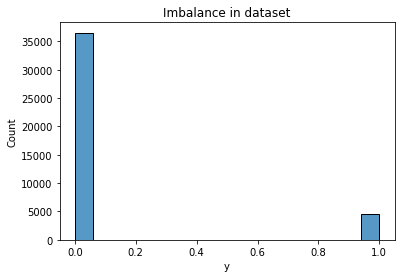

In [ ]:
sns_plot = sns.histplot(df_dummies.y, kde=False).set_title('Imbalance in dataset')

In [ ]:
np.mean(df_dummies.y)

0.11265417111780131

# Model the data:

Using the train_test_split function in scikit-learn, separate your dataset into a training and a test set, with a test size of 20% and random_state=50. Make sure the train/test split is stratified (and check that it is!). Stratified means that the percentages of classes in each fold remains constant

In [ ]:
x = df_dummies.loc[:, df_dummies.columns != 'y'].to_numpy()
y = df_dummies.loc[:, 'y'].to_numpy()
print(x.shape, y.shape)

(41188, 62) (41188,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
print(np.mean(y_train))
print(np.mean(y_test))

0.11265553869499241
0.11264870114105366


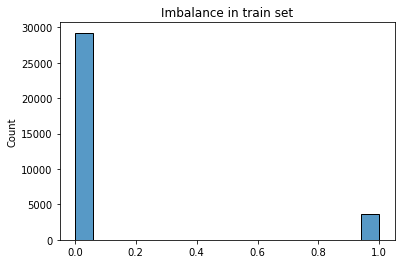

In [ ]:
sns_plot = sns.histplot(y_train, kde=False).set_title('Imbalance in train set')

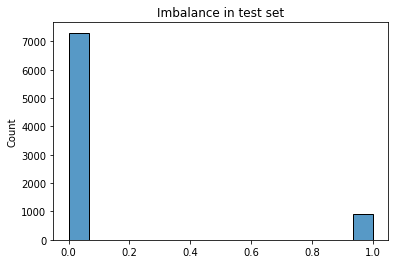

In [ ]:
sns_plot = sns.histplot(y_test, kde=False).set_title('Imbalance in test set')

Report the results of 10-fold stratified cross-validation on the training set using a random forest classifier with 100 trees and depth=3. Ensure you're using an appropriate metric (Use sorted(sklearn.metrics.SCORERS.keys()) to see what are the valid options)

In [ ]:
RFclf = RandomForestClassifier(n_estimators=100, max_depth=3)
SKF10 = StratifiedKFold(n_splits=10)
scores = cross_val_score(RFclf, x_train, y_train, cv=SKF10, scoring="f1")
print("F1: %.2f +/- %.2f" % (scores.mean(), scores.std()))

F1: 0.24 +/- 0.04


Compare the results of your classifier with that of a dummy classifier

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, x_train, y_train, cv=SKF10, scoring="f1")
print("F1: %.2f +/- %.2f" % (scores.mean(), scores.std()))

F1: 0.11 +/- 0.01


Use GridSearchCV to find a better set of parameters for your random forest

In [ ]:
RFclf = RandomForestClassifier(n_estimators=100, max_depth=3)
param_grid = {
    # 'criterion' : ["entropy", "gini"],
    'max_depth' : np.arange(3, 10, 2),
    'n_estimators' : np.arange(80, 121, 20),
}
RFclf = GridSearchCV(estimator=RFclf, param_grid=param_grid, n_jobs=-1)
RFclf = RFclf.fit(x_train, y_train)
print('Best parameters: ', RFclf.best_params_)

Best parameters:  {'max_depth': 9, 'n_estimators': 120}


Print the cross-validation metric (whichever you previously chose) that you obtain for the random forest for the best parameters found with GridSearchCV

In [ ]:
scores = cross_val_score(RFclf.best_estimator_, x_train, y_train, cv=SKF10, scoring="f1") 
print("F1: %.2f +/- %.2f" % (scores.mean(), scores.std()))

F1: 0.32 +/- 0.04


What are the top 3 features?

In [ ]:
importances = RFclf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFclf.best_estimator_.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print(indices)

[ 7  8  2  4  6  5 61  0  3 49 60  1 59 43 52 42 50 44 55 48 31 53 14 57
 34 33 56 23 54 17 58 10 28 38 36 22 39 18 27 30  9 41 51 21 45 47 32 25
 26 16 13 15 19 46 40 37 20 12 11 24 29 35]


In [ ]:
features = df_dummies.columns.tolist()
features.remove('y')

In [ ]:
# Print the feature ranking
print("Feature ranking:")

for f in range(3):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

Feature ranking:
1. euribor3m (0.158637)
2. nr.employed (0.138711)
3. pdays (0.115345)


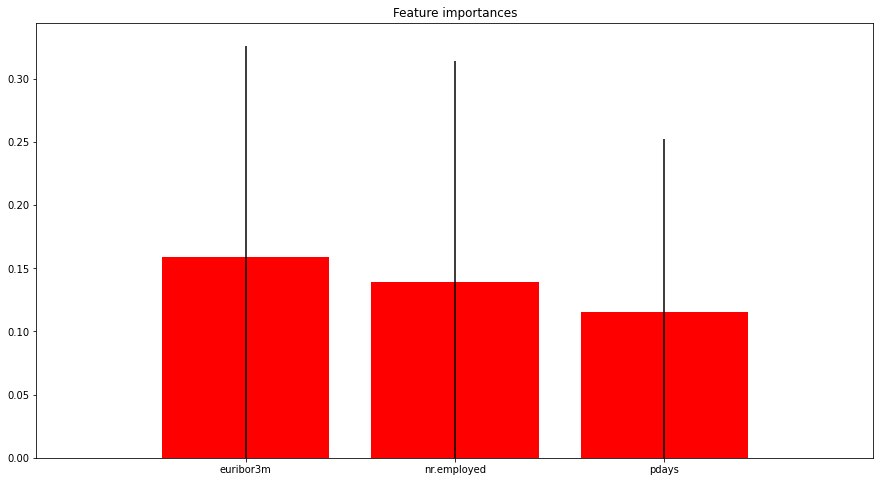

In [ ]:
# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(3), importances[indices][0:3],
       color="r", yerr=std[indices][0:3], align="center")
plt.xticks(range(3), np.array(features)[indices])
plt.xlim([-1, 3])
plt.ylim([0, None])

fig.set_size_inches(15, 8)

Report the generalisation error (still using the same metric) on your test set

In [ ]:
# Predict using test dataset
y_predict = RFclf.best_estimator_.predict(x_test)
# Model Performance
score = metrics.f1_score(y_test, y_predict)
print('F1:', score)
cm = confusion_matrix(y_test, y_predict)
print(cm)
print("Report : \n", metrics.classification_report(y_test, y_predict)) 

F1: 0.33009708737864074
[[7206  104]
 [ 724  204]]
Report : 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.66      0.22      0.33       928

    accuracy                           0.90      8238
   macro avg       0.79      0.60      0.64      8238
weighted avg       0.88      0.90      0.88      8238

